Import Libraries and Load CIFAR-10 Dataset

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

# Load dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
class_names = ["Airplane", "Automobile", "Bird", "Cat", "Deer", "Dog", "Frog", "Horse", "Ship", "Truck"]

# One-hot encode the labels
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Dataset Information

In [2]:
print(f"Training Data Shape: {x_train.shape}")
print(f"Testing Data Shape: {x_test.shape}")
print(f"Number of Classes: {len(class_names)}")
print(f"Class Names: {class_names}")


Training Data Shape: (50000, 32, 32, 3)
Testing Data Shape: (10000, 32, 32, 3)
Number of Classes: 10
Class Names: ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']


Basic Statistics

In [3]:
print("Training Data Statistics:")
print(f"Min Pixel Value: {x_train.min()}, Max Pixel Value: {x_train.max()}")
print(f"Mean Pixel Value: {x_train.mean():.2f}, Std Dev: {x_train.std():.2f}")


Training Data Statistics:
Min Pixel Value: 0, Max Pixel Value: 255
Mean Pixel Value: 120.71, Std Dev: 64.15


Display Sample Images

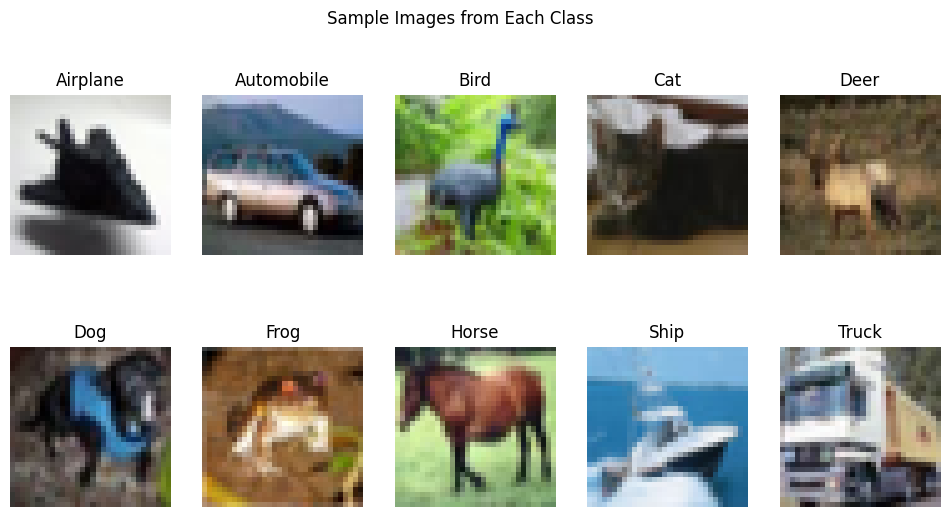

In [4]:
plt.figure(figsize=(12, 6))
for i in range(10):
    index = np.where(y_train[:, i] == 1)[0][0]
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_train[index])
    plt.title(class_names[i])
    plt.axis("off")
plt.suptitle("Sample Images from Each Class")
plt.show()


Normalize Data

In [5]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0


Class Distribution

<ipython-input-6-a95a07099f30>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=train_labels, palette="viridis")
<ipython-input-6-a95a07099f30>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=test_labels, palette="viridis")


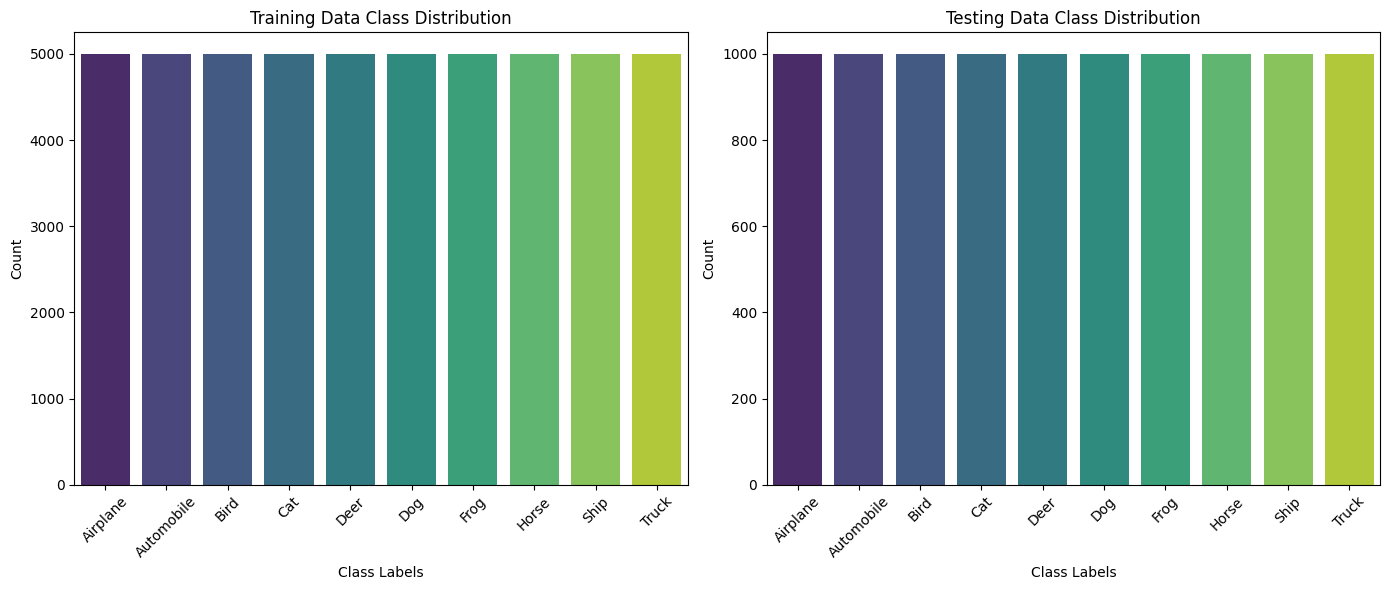

In [6]:
train_labels = np.argmax(y_train, axis=1)
test_labels = np.argmax(y_test, axis=1)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.countplot(x=train_labels, palette="viridis")
plt.title("Training Data Class Distribution")
plt.xlabel("Class Labels")
plt.ylabel("Count")
plt.xticks(ticks=np.arange(10), labels=class_names, rotation=45)

plt.subplot(1, 2, 2)
sns.countplot(x=test_labels, palette="viridis")
plt.title("Testing Data Class Distribution")
plt.xlabel("Class Labels")
plt.ylabel("Count")
plt.xticks(ticks=np.arange(10), labels=class_names, rotation=45)

plt.tight_layout()
plt.show()


Data Augmentation

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(x_train)


Display Augmented Images

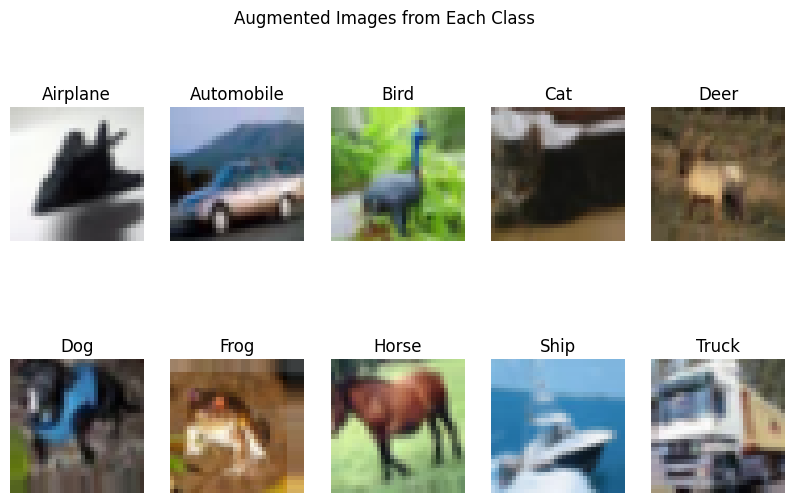

In [8]:
plt.figure(figsize=(10, 6))
for i in range(10):
    augmented_img = datagen.flow(x_train[np.where(np.argmax(y_train, axis=1) == i)[0][:1]], batch_size=1)[0]
    plt.subplot(2, 5, i + 1)
    plt.imshow(augmented_img[0])
    plt.title(class_names[i])
    plt.axis("off")
plt.suptitle("Augmented Images from Each Class")
plt.show()


Build Basic CNN Model

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

def build_cnn_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.2),

        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.3),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.4),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


Build ResNet Model

In [10]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model

def build_resnet_model():
    base_model = ResNet50(weights=None, include_top=False, input_shape=(32, 32, 3))
    x = Flatten()(base_model.output)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.4)(x)
    output = Dense(10, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


Train CNN Model

In [11]:
cnn_model = build_cnn_model()
history_cnn = cnn_model.fit(
    datagen.flow(x_train, y_train, batch_size=64),
    validation_data=(x_test, y_test),
    epochs=25
)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


782/782 ━━━━━━━━━━━━━━━━━━━━ 209s 263ms/step - accuracy: 0.2653 - loss: 2.0126 - val_accuracy: 0.4870 - val_loss: 1.4280
Epoch 2/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 235s 300ms/step - accuracy: 0.4384 - loss: 1.5283 - val_accuracy: 0.5102 - val_loss: 1.4086
Epoch 3/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 230s 259ms/step - accuracy: 0.5091 - loss: 1.3664 - val_accuracy: 0.5430 - val_loss: 1.2808
Epoch 4/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 203s 260ms/step - accuracy: 0.5591 - loss: 1.2390 - val_accuracy: 0.6176 - val_loss: 1.0666
Epoch 5/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 242s 309ms/step - accuracy: 0.5981 - loss: 1.1482 - val_accuracy: 0.6636 - val_loss: 0.9744
Epoch 6/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 223s 259ms/step - accuracy: 0.6171 - loss: 1.0898 - val_accuracy: 0.6143 - val_loss: 1.1104
Epoch 7/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 264s 261ms/step - accuracy: 0.6339 - loss: 1.0449 - val_accuracy: 0.6670 - val_loss: 0.9731
Epoch 8/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 207s 264ms/step - accuracy: 0.6544 - loss: 1.00

Train ResNet Model

In [13]:
resnet_model = build_resnet_model()
history_resnet = resnet_model.fit(
    datagen.flow(x_train, y_train, batch_size=64),
    validation_data=(x_test, y_test),
    epochs=10
)


Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 3044s 4s/step - accuracy: 0.1473 - loss: 2.3216 - val_accuracy: 0.1687 - val_loss: 2.1209
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 3066s 4s/step - accuracy: 0.1723 - loss: 2.0995 - val_accuracy: 0.2042 - val_loss: 1.9767
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 3000s 4s/step - accuracy: 0.1836 - loss: 2.0627 - val_accuracy: 0.2175 - val_loss: 1.9872
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 2997s 4s/step - accuracy: 0.1923 - loss: 2.0459 - val_accuracy: 0.2008 - val_loss: 2.0186
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 2991s 4s/step - accuracy: 0.1936 - loss: 2.0400 - val_accuracy: 0.2158 - val_loss: 1.9478
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 3017s 4s/step - accuracy: 0.1884 - loss: 2.0567 - val_accuracy: 0.1883 - val_loss: 2.1419
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 3048s 4s/step - accuracy: 0.1848 - loss: 2.0606 - val_accuracy: 0.2159 - val_loss: 1.9645
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 3024s 4s/step - accuracy: 0.1894 - loss: 2.0359 - 

Visualize Learning Curves

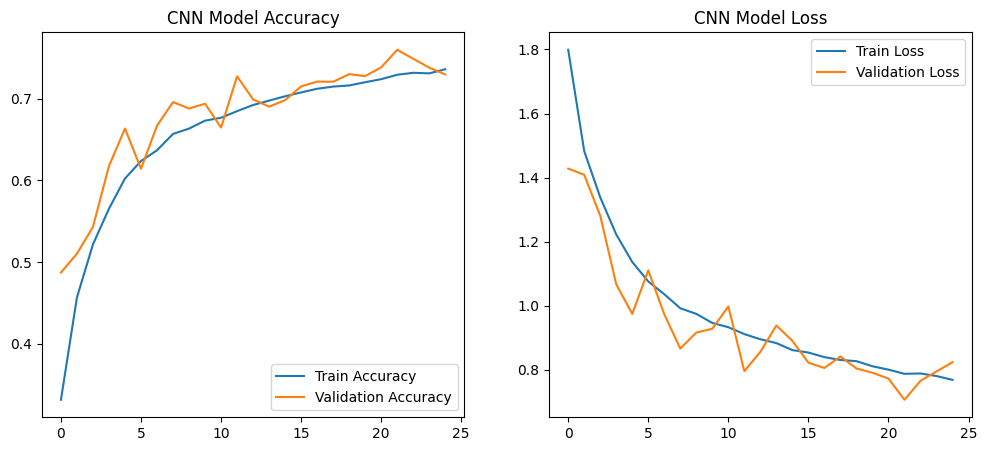

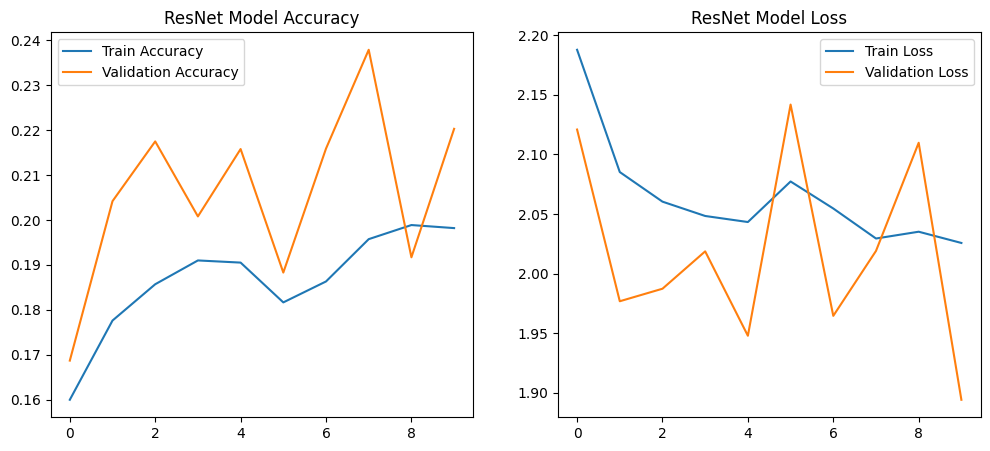

In [15]:
def plot_learning_curves(history, title):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} Loss')
    plt.legend()

    plt.show()

plot_learning_curves(history_cnn, "CNN Model")
plot_learning_curves(history_resnet, "ResNet Model")


Evaluate Models

In [16]:
cnn_results = cnn_model.evaluate(x_test, y_test, verbose=0)
resnet_results = resnet_model.evaluate(x_test, y_test, verbose=0)

print(f"CNN Model - Accuracy: {cnn_results[1]:.4f}")
print(f"ResNet Model - Accuracy: {resnet_results[1]:.4f}")


CNN Model - Accuracy: 0.7299
ResNet Model - Accuracy: 0.2203


Generate Classification Report

In [17]:
from sklearn.metrics import classification_report

def generate_report(model, x_test, y_test):
    y_pred = np.argmax(model.predict(x_test), axis=1)
    y_true = np.argmax(y_test, axis=1)
    report = classification_report(y_true, y_pred, target_names=class_names)
    print(report)

generate_report(cnn_model, x_test, y_test)
generate_report(resnet_model, x_test, y_test)


313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step
              precision    recall  f1-score   support

    Airplane       0.80      0.77      0.79      1000
  Automobile       0.86      0.92      0.89      1000
        Bird       0.79      0.55      0.65      1000
         Cat       0.68      0.39      0.50      1000
        Deer       0.84      0.57      0.68      1000
         Dog       0.85      0.50      0.63      1000
        Frog       0.50      0.96      0.66      1000
       Horse       0.77      0.82      0.79      1000
        Ship       0.84      0.88      0.86      1000
       Truck       0.68      0.94      0.79      1000

    accuracy                           0.73     10000
   macro avg       0.76      0.73      0.72     10000
weighted avg       0.76      0.73      0.72     10000

313/313 ━━━━━━━━━━━━━━━━━━━━ 45s 137ms/step
              precision    recall  f1-score   support

    Airplane       0.15      0.12      0.13      1000
  Automobile       0.24      0.94      0.39  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Save Models

In [18]:
cnn_model.save("cnn_model.h5")
resnet_model.save("resnet_model.h5")


Compare Model Performances

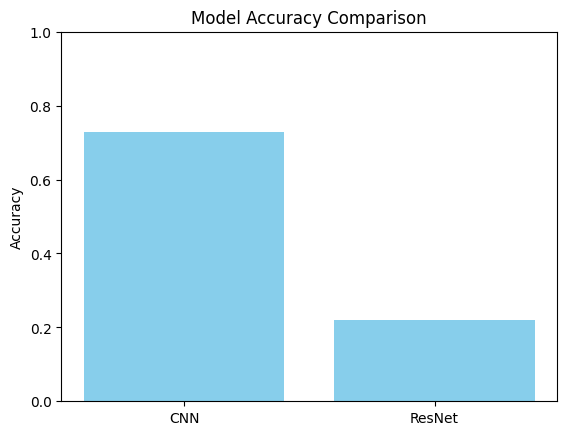

In [19]:
models = ["CNN", "ResNet"]
accuracies = [cnn_results[1], resnet_results[1]]

plt.bar(models, accuracies, color="skyblue")
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.show()


Confusion Matrix for CNN

313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step


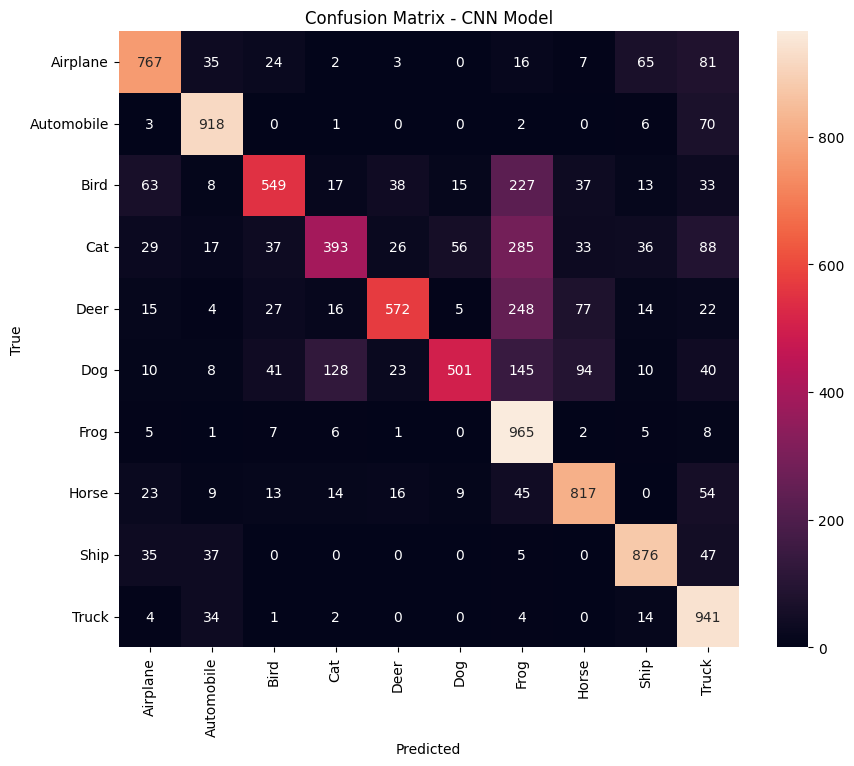

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred_cnn = np.argmax(cnn_model.predict(x_test), axis=1)
y_true = np.argmax(y_test, axis=1)
conf_matrix = confusion_matrix(y_true, y_pred_cnn)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - CNN Model")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


Confusion Matrix for ResNet

313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 132ms/step


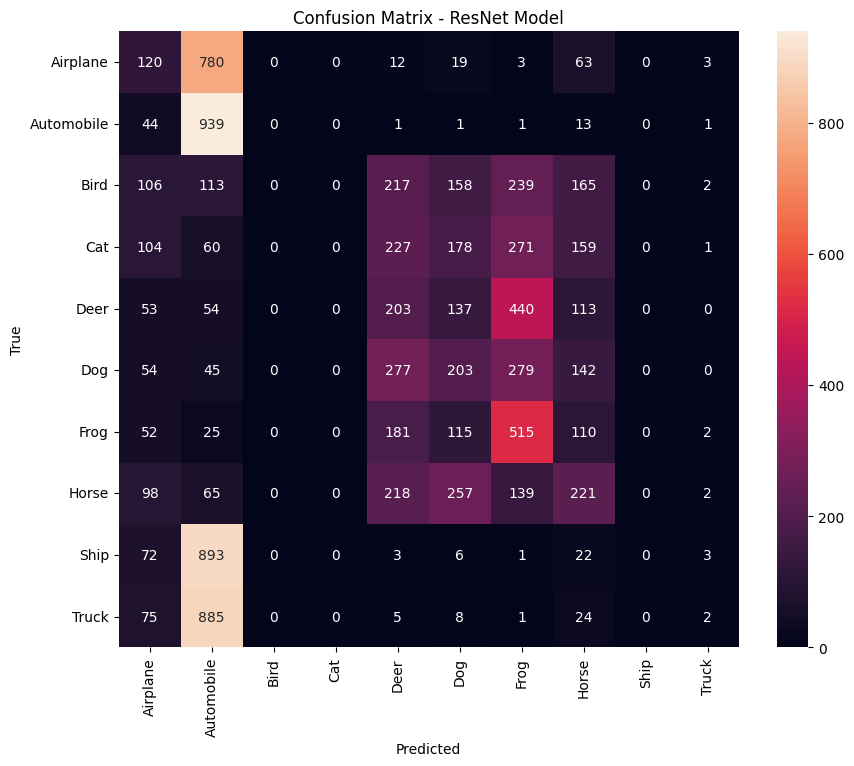

In [21]:
y_pred_resnet = np.argmax(resnet_model.predict(x_test), axis=1)
conf_matrix_resnet = confusion_matrix(y_true, y_pred_resnet)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_resnet, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - ResNet Model")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


PCA Visualization

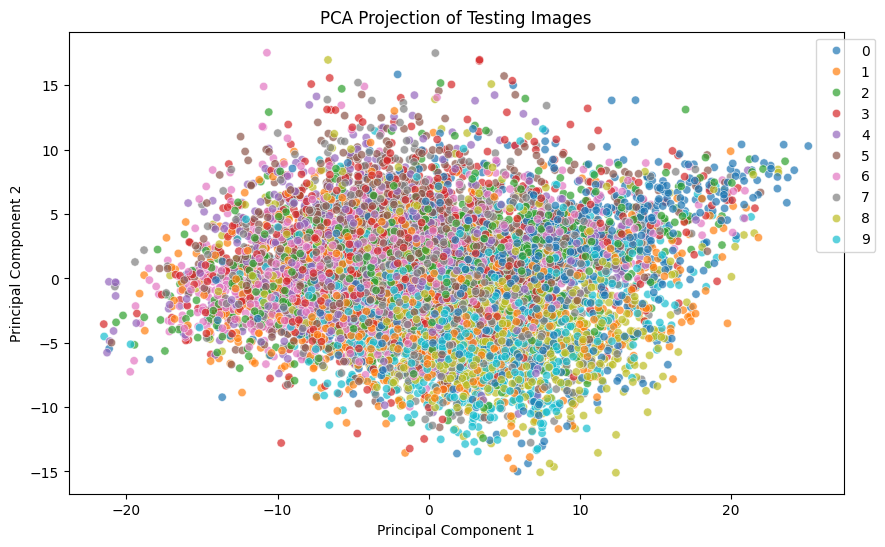

In [14]:
from sklearn.decomposition import PCA

flattened_images = x_test.reshape(x_test.shape[0], -1)
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(flattened_images)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=np.argmax(y_test, axis=1), palette="tab10", alpha=0.7)
plt.title("PCA Projection of Testing Images")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(loc="best", bbox_to_anchor=(1.05, 1))
plt.show()
